In [2]:
import math
import matplotlib.pyplot as plt
import time
from pynq import overlay
import numpy as np
import struct
from scipy.misc import imread
import cv2
from driver import *
from FRC_WB import *
from FRC_FM import *
from pynq import Xlnk

In [3]:
# Conv1
IN_WIDTH1 = 28
IN_HEIGHT1 = 28
IN_CH1 = 1

KERNEL_WIDTH1 = 5
KERNEL_HEIGHT1 = 5
X_STRIDE1 = 1
Y_STRIDE1 = 1

RELU_EN1 = 1
MODE1 = 1  # 0:VALID, 1:SAME
if MODE1:
    X_PADDING1 = int((KERNEL_WIDTH1 - 1) / 2)  # 2
    Y_PADDING1 = int((KERNEL_HEIGHT1 - 1) / 2)
else:
    X_PADDING1 = 0
    Y_PADDING1 = 0

OUT_CH1 = 6
OUT_WIDTH1 = int((IN_WIDTH1 + 2 * X_PADDING1 - KERNEL_WIDTH1) / X_STRIDE1 + 1)  # 28+4-5+1
OUT_HEIGHT1 = int((IN_HEIGHT1 + 2 * Y_PADDING1 - KERNEL_HEIGHT1) / Y_STRIDE1 + 1)

# Pool1
IN_WIDTH11 = OUT_WIDTH1  # 28
IN_HEIGHT11 = OUT_HEIGHT1  # 28
IN_CH11 = OUT_CH1  # 6

KERNEL_WIDTH11 = 2
KERNEL_HEIGHT11 = 2

OUT_CH11 = IN_CH11  # 6
OUT_WIDTH11 = int(IN_WIDTH11 / KERNEL_WIDTH11)  # 14
OUT_HEIGHT11 = int(IN_HEIGHT11 / KERNEL_HEIGHT11)  # 14

# Conv2
IN_WIDTH2 = OUT_WIDTH11  # 14
IN_HEIGHT2 = OUT_HEIGHT11  # 14
IN_CH2 = OUT_CH11  # 6

KERNEL_WIDTH2 = 5
KERNEL_HEIGHT2 = 5
X_STRIDE2 = 1
Y_STRIDE2 = 1

RELU_EN2 = 1
MODE2 = 0  # 0:VALID, 1:SAME
if MODE2:
    X_PADDING2 = int((KERNEL_WIDTH2 - 1) / 2)  # 2
    Y_PADDING2 = int((KERNEL_HEIGHT2 - 1) / 2)  # 2
else:
    X_PADDING2 = 0
    Y_PADDING2 = 0

OUT_CH2 = 16
OUT_WIDTH2 = int((IN_WIDTH2 + 2 * X_PADDING2 - KERNEL_WIDTH2) / X_STRIDE2 + 1)  # 14+0-5+1
OUT_HEIGHT2 = int((IN_HEIGHT2 + 2 * Y_PADDING2 - KERNEL_HEIGHT2) / Y_STRIDE2 + 1)  # 14+0-5+1

# Pool2
IN_WIDTH21 = OUT_WIDTH2  # 10
IN_HEIGHT21 = OUT_HEIGHT2  # 10
IN_CH21 = OUT_CH2  # 16

KERNEL_WIDTH21 = 2
KERNEL_HEIGHT21 = 2

OUT_CH21 = IN_CH21  # 16
OUT_WIDTH21 = int(IN_WIDTH21 / KERNEL_WIDTH21)  # 5
OUT_HEIGHT21 = int(IN_HEIGHT21 / KERNEL_HEIGHT21)  # 5

# Fc1
IN_WIDTH3 = OUT_WIDTH21  # 5
IN_HEIGHT3 = OUT_HEIGHT21  # 5
IN_CH3 = OUT_CH21  # 16

KERNEL_WIDTH3 = 5
KERNEL_HEIGHT3 = 5
X_STRIDE3 = 1
Y_STRIDE3 = 1

RELU_EN3 = 1
MODE3 = 0  # 0:VALID, 1:SAME
if MODE3:
    X_PADDING3 = int((KERNEL_WIDTH3 - 1 / 2))
    Y_PADDING3 = int((KERNEL_HEIGHT3 - 1) / 2)
else:
    X_PADDING3 = 0
    Y_PADDING3 = 0

OUT_CH3 = 120
OUT_WIDTH3 = int((IN_WIDTH3 + 2 * X_PADDING3 - KERNEL_WIDTH3) / X_STRIDE3 + 1)  # 5+0-5+1
OUT_HEIGHT3 = int((IN_HEIGHT3 + 2 * Y_PADDING3 - KERNEL_HEIGHT3) / Y_STRIDE3 + 1)

# Fc2
IN_WIDTH4 = OUT_WIDTH3
IN_HEIGHT4 = OUT_HEIGHT3
IN_CH4 = OUT_CH3

KERNEL_WIDTH4 = 1
KERNEL_HEIGHT4 = 1
X_STRIDE4 = 1
Y_STRIDE4 = 1

RELU_EN4 = 1
MODE4 = 0  # 0:VALID, 1:SAME
if MODE4:
    X_PADDING4 = int((KERNEL_WIDTH4 - 1 / 2))
    Y_PADDING4 = int((KERNEL_HEIGHT4 - 1) / 2)
else:
    X_PADDING4 = 0
    Y_PADDING4 = 0

OUT_CH4 = 84
OUT_WIDTH4 = int((IN_WIDTH4 + 2 * X_PADDING4 - KERNEL_WIDTH4) / X_STRIDE4 + 1)
OUT_HEIGHT4 = int((IN_HEIGHT4 + 2 * Y_PADDING4 - KERNEL_HEIGHT4) / Y_STRIDE4 + 1)

# Fc3
IN_WIDTH5 = OUT_WIDTH4
IN_HEIGHT5 = OUT_HEIGHT4
IN_CH5 = OUT_CH4

KERNEL_WIDTH5 = 1
KERNEL_HEIGHT5 = 1
X_STRIDE5 = 1
Y_STRIDE5 = 1

RELU_EN5 = 1
MODE5 = 0  # 0:VALID, 1:SAME
if MODE5:
    X_PADDING5 = int((KERNEL_WIDTH5 - 1 / 2))
    Y_PADDING5 = int((KERNEL_HEIGHT5 - 1) / 2)
else:
    X_PADDING5 = 0
    Y_PADDING5 = 0

OUT_CH5 = 10
OUT_WIDTH5 = int((IN_WIDTH5 + 2 * X_PADDING5 - KERNEL_WIDTH5) / X_STRIDE5 + 1)
OUT_HEIGHT5 = int((IN_HEIGHT5 + 2 * Y_PADDING5 - KERNEL_HEIGHT5) / Y_STRIDE5 + 1)

ol = Overlay("soc.bit")
ol.download()
dma = ol.axi_dma_0
conv = ol.conv_0
pool = ol.pool_0
print("overlay successfully downloaded.")

overlay successfully downloaded.


In [4]:
xlnk = Xlnk()
# input image
image = xlnk.cma_array(shape=(IN_CH1, IN_HEIGHT1, IN_WIDTH1, K), cacheable=0, dtype=np.int16)

# conv1 and pool1: weight, bias, conv1 o.f. map, pool1 o.f. map
W_conv1 = xlnk.cma_array(shape=(OUT_CH1, KERNEL_HEIGHT1, KERNEL_WIDTH1, math.ceil(IN_CH1 / K), K),
                         cacheable=0, dtype=np.int16)
B_conv1 = xlnk.cma_array(shape=OUT_CH1, cacheable=0, dtype=np.int16)
conv1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH1 / K), OUT_HEIGHT1, OUT_WIDTH1, K), cacheable=0, dtype=np.int16)
pool1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH11 / K), OUT_HEIGHT11, OUT_WIDTH11, K), cacheable=0, dtype=np.int16)

# conv2 and pool2: weight, bias, conv2 o.f. map, pool2 o.f. map
W_conv2 = xlnk.cma_array(shape=(OUT_CH2, KERNEL_HEIGHT2, KERNEL_WIDTH2, math.ceil(IN_CH2 / K), K),
                         cacheable=0, dtype=np.int16)
B_conv2 = xlnk.cma_array(shape=OUT_CH2, cacheable=0, dtype=np.int16)
conv2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH2 / K), OUT_HEIGHT2, OUT_WIDTH2, K), cacheable=0, dtype=np.int16)
pool2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH21 / K), OUT_HEIGHT21, OUT_WIDTH21, K), cacheable=0, dtype=np.int16)

# fc1: weight, bias, fc1 o.f. map
W_fc1 = xlnk.cma_array(shape=(OUT_CH3, KERNEL_HEIGHT3, KERNEL_WIDTH3, math.ceil(IN_CH3 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc1 = xlnk.cma_array(shape=OUT_CH3, cacheable=0, dtype=np.int16)
fc1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH3 / K), OUT_HEIGHT3, OUT_WIDTH3, K), cacheable=0, dtype=np.int16)

# fc2: weight, bias, fc2 o.f. map
W_fc2 = xlnk.cma_array(shape=(OUT_CH4, KERNEL_HEIGHT4, KERNEL_WIDTH4, math.ceil(IN_CH4 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc2 = xlnk.cma_array(shape=OUT_CH4, cacheable=0, dtype=np.int16)
fc2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH4 / K), OUT_HEIGHT4, OUT_WIDTH4, K), cacheable=0, dtype=np.int16)

# fc3: weight, bias, fc3 o.f. map
W_fc3 = xlnk.cma_array(shape=(OUT_CH5, KERNEL_HEIGHT5, KERNEL_WIDTH5, math.ceil(IN_CH5 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc3 = xlnk.cma_array(shape=OUT_CH5, cacheable=0, dtype=np.int16)
fc3_ofv_10 = xlnk.cma_array(shape=(math.ceil(OUT_CH5 / K), OUT_HEIGHT5, OUT_WIDTH5, K), cacheable=0, dtype=np.int16)

In [5]:
xlnk = Xlnk()
# input image
image = xlnk.cma_array(shape=( math.ceil(IN_CH1 /K), IN_HEIGHT1, IN_WIDTH1, K), cacheable=0, dtype=np.int16)

# conv1 and pool1: weight, bias, conv1 o.f. map, pool1 o.f. map
W_conv1 = xlnk.cma_array(shape=(OUT_CH1, KERNEL_HEIGHT1, KERNEL_WIDTH1, math.ceil(IN_CH1 / K), K),
                         cacheable=0, dtype=np.int16)
B_conv1 = xlnk.cma_array(shape=OUT_CH1, cacheable=0, dtype=np.int16)
conv1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH1 / K), OUT_HEIGHT1, OUT_WIDTH1, K), cacheable=0, dtype=np.int16)
pool1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH11 / K), OUT_HEIGHT11, OUT_WIDTH11, K), cacheable=0, dtype=np.int16)

# conv2 and pool2: weight, bias, conv2 o.f. map, pool2 o.f. map
W_conv2 = xlnk.cma_array(shape=(OUT_CH2, KERNEL_HEIGHT2, KERNEL_WIDTH2, math.ceil(IN_CH2 / K), K),
                         cacheable=0, dtype=np.int16)
B_conv2 = xlnk.cma_array(shape=OUT_CH2, cacheable=0, dtype=np.int16)
conv2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH2 / K), OUT_HEIGHT2, OUT_WIDTH2, K), cacheable=0, dtype=np.int16)
pool2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH21 / K), OUT_HEIGHT21, OUT_WIDTH21, K), cacheable=0, dtype=np.int16)

# fc1: weight, bias, fc1 o.f. map
W_fc1 = xlnk.cma_array(shape=(OUT_CH3, KERNEL_HEIGHT3, KERNEL_WIDTH3, math.ceil(IN_CH3 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc1 = xlnk.cma_array(shape=OUT_CH3, cacheable=0, dtype=np.int16)
fc1_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH3 / K), OUT_HEIGHT3, OUT_WIDTH3, K), cacheable=0, dtype=np.int16)

# fc2: weight, bias, fc2 o.f. map
W_fc2 = xlnk.cma_array(shape=(OUT_CH4, KERNEL_HEIGHT4, KERNEL_WIDTH4, math.ceil(IN_CH4 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc2 = xlnk.cma_array(shape=OUT_CH4, cacheable=0, dtype=np.int16)
fc2_ofm = xlnk.cma_array(shape=(math.ceil(OUT_CH4 / K), OUT_HEIGHT4, OUT_WIDTH4, K), cacheable=0, dtype=np.int16)

# fc3: weight, bias, fc3 o.f. map
W_fc3 = xlnk.cma_array(shape=(OUT_CH5, KERNEL_HEIGHT5, KERNEL_WIDTH5, math.ceil(IN_CH5 / K), K),
                       cacheable=0, dtype=np.int16)
B_fc3 = xlnk.cma_array(shape=OUT_CH5, cacheable=0, dtype=np.int16)
fc3_ofv_10 = xlnk.cma_array(shape=(math.ceil(OUT_CH5 / K), OUT_HEIGHT5, OUT_WIDTH5, K), cacheable=0, dtype=np.int16)

# Initialise weight and bias
Load_Weight_From_File(W_conv1, "data/W_conv1.bin")
b_conv1 = readbinfile("data/b_conv1.bin", OUT_CH1)
for i in range(OUT_CH1):
    B_conv1[i] = b_conv1[i]

Load_Weight_From_File(W_conv2, "data/W_conv2.bin")
b_conv2 = readbinfile("data/b_conv2.bin", OUT_CH2)
for i in range(OUT_CH2):
    B_conv2[i] = b_conv2[i]

Load_Weight_From_File(W_fc1, "data/W_fc1.bin")
b_fc1 = readbinfile("data/b_fc1.bin", OUT_CH3)
for i in range(OUT_CH3):
    B_fc1[i] = b_fc1[i]

Load_Weight_From_File(W_fc2, "data/W_fc2.bin")
b_fc2 = readbinfile("data/b_fc2.bin", OUT_CH4)
for i in range(OUT_CH4):
    B_fc2[i] = b_fc2[i]

Load_Weight_From_File(W_fc3, "data/W_fc3.bin")
b_fc3 = readbinfile("data/b_fc3.bin", OUT_CH5)
for i in range(OUT_CH5):
    B_fc3[i] = b_fc3[i]

print("Initialisation finished." + "\n")
print("------------------------------------------------------------------")

Initialisation finished.

------------------------------------------------------------------


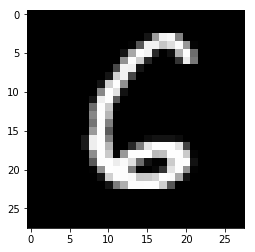

In [14]:
test_pic = 98
img_gray = np.zeros((28, 28))
with open("data/t10k-images.idx3-ubyte", 'rb') as fp:
    dat = fp.read(16 + 28 * 28 * test_pic)
    for i in range(28):
        for j in range(28):
            dat = fp.read(1)
            a = struct.unpack("B", dat)
            img_gray[i][j] = a[0]
img_gray = img_gray.astype(np.uint8)
plt.imshow(cv2.merge([img_gray,img_gray,img_gray]))
plt.show()

In [15]:
for i in range(np.shape(img_gray)[0]):
    for j in range(np.shape(img_gray)[1]):
        image[0][i][j][0] = int((img_gray[i][j] / 255) * (2 ** FRC_IMG))

In [ ]:
# Timer started
start_time = time.process_time()

# conv1 & pool1
RunConv(conv, IN_CH1, OUT_CH1, 
        KERNEL_WIDTH1, KERNEL_HEIGHT1, X_STRIDE1, Y_STRIDE1, 
        MODE1, RELU_EN1,
        image, FRC_IMG,
        B_conv1, FRC_B_CONV1,
        W_conv1, FRC_W_CONV1,
        conv1_ofm, FRC_CONV1_OFM)

RunPool(pool, dma, OUT_CH1, KERNEL_WIDTH11, KERNEL_HEIGHT11,
        conv1_ofm,
        pool1_ofm)

# conv2 and pool2
RunConv(conv, IN_CH2, OUT_CH2, 
        KERNEL_WIDTH2, KERNEL_HEIGHT2, X_STRIDE2, Y_STRIDE2, 
        MODE2, RELU_EN2,
        pool1_ofm, FRC_POOL1_OFM,
        B_conv2, FRC_B_CONV2,
        W_conv2, FRC_W_CONV2,
        conv2_ofm, FRC_CONV2_OFM)

RunPool(pool, dma, OUT_CH2, KERNEL_WIDTH21, KERNEL_HEIGHT21,
        conv2_ofm,
        pool2_ofm)

# fc1
RunConv(conv, IN_CH3, OUT_CH3, 
        KERNEL_WIDTH3, KERNEL_HEIGHT3, X_STRIDE3, Y_STRIDE3, 
        MODE3, RELU_EN3,
        pool2_ofm, FRC_POOL2_OFM,
        B_fc1, FRC_B_FC1,
        W_fc1, FRC_W_FC1,
        fc1_ofm, FRC_FC1_OFM)

# fc2
RunConv(conv, IN_CH4, OUT_CH4, 
        KERNEL_WIDTH4, KERNEL_HEIGHT4, X_STRIDE4, Y_STRIDE4, 
        MODE4, RELU_EN4,
        fc1_ofm, FRC_FC1_OFM,
        B_fc2, FRC_B_FC2,
        W_fc2, FRC_W_FC2,
        fc2_ofm, FRC_FC2_OFM)
    
# fc3
RunConv(conv, IN_CH5, OUT_CH5, 
        KERNEL_WIDTH5, KERNEL_HEIGHT5, X_STRIDE5, Y_STRIDE5, 
        MODE5, RELU_EN5,
        fc2_ofm, FRC_FC2_OFM,
        B_fc3, FRC_B_FC3,
        W_fc3, FRC_W_FC3,
        fc3_ofv_10, FRC_FC3_OFV)

# Timer finished
end_time = time.process_time()

print("FPGA acceleration finished")


In [13]:
MAX = 0
result = 0
for i in range(1, 10):
    if fc3_ofv_10[i // K][0][0][i % K] > MAX:
        MAX = fc3_ofv_10[i // K][0][0][i % K]
        result = i
print("Inference done.The number you wrote is " + str(result) + ". Elapsed inference time:" + str(
       1000 * end_time - 1000 * start_time) + "ms" + "\n")

Inference done.The number you wrote is 6. Elapsed inference time:37.735414999995555ms

